In [1]:
# try:
  # This command only in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf

from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization, InputLayer #type: ignore
# from tensorflow.keras.preprocessing.image import ImageDataGenerator #type: ignore - ImageDataGenerator is deprecated so image_dataset_from_directory will be used insted 
from tensorflow.keras.preprocessing import image_dataset_from_directory #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.losses import CategoricalCrossentropy #type: ignore

import os
import numpy as np
import matplotlib.pyplot as plt

2024-11-27 21:28:56.868189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732742936.883869    9341 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732742936.888581    9341 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 21:28:56.904662: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Get project files
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# !unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
# total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
# total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
# total_test = len(os.listdir(test_dir))

total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150
img_size = (IMG_HEIGHT, IMG_WIDTH)

In [3]:
# 3
train_data_gen = image_dataset_from_directory(train_dir,
                                              labels = 'inferred',
                                              label_mode = 'int',
                                              color_mode = 'rgb',
                                              image_size = img_size,
                                              batch_size = batch_size)
val_data_gen = image_dataset_from_directory(validation_dir,
                                            labels = 'inferred',
                                            label_mode = 'int',
                                            color_mode = 'rgb',
                                            image_size = img_size,
                                            batch_size = batch_size)
test_data_gen = image_dataset_from_directory(test_dir,
                                             labels = None,
                                             color_mode = 'rgb',
                                             image_size = img_size)

Found 2000 files belonging to 2 classes.


I0000 00:00:1732742949.287595    9341 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7623 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:2d:00.0, compute capability: 8.9


Found 1000 files belonging to 2 classes.
Found 50 files.


2024-11-27 21:29:13.707418: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-27 21:29:13.811019: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-27 21:29:14.035678: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


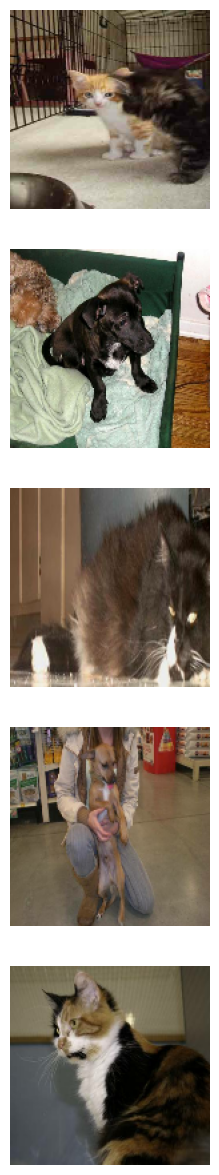

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip(images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

def sample_images_arr(dataset, num_images = 5):
    ds_list = list(dataset.unbatch().as_numpy_iterator())
    random_list = np.random.randint(0, len(ds_list) - 1, num_images).tolist()

    img_arr = []
    for i in random_list:
        for image, label in dataset.unbatch().skip(i).take(1):
            image = image.numpy().astype('uint8')
            img_arr.append(image)
    
    return img_arr

img_arr = sample_images_arr(train_data_gen)     
plotImages(img_arr)


In [5]:
# 5
def data_augmentation(dataset):
    def flip_horizontal(image, label):
        image = tf.image.flip_left_right(image)
        return tf.image.resize(image, (img_size)), label
    
    def random_contrast(image, label):
        image = tf.image.random_contrast(image, 0.1, 0.6)
        return tf.image.resize(image, (img_size)), label
    
    def random_brightness(image, label):
        image = tf.image.random_brightness(image, max_delta = 0.15)
        return tf.image.resize(image, (img_size)), label
    
    def central_crop(image, label):
        image = tf.image.central_crop(image, central_fraction = 0.7)
        return tf.image.resize(image, (img_size)), label
    
    ds = dataset.map(flip_horizontal)
    return_ds = dataset.concatenate(ds)
    ds = dataset.map(random_contrast)
    return_ds = return_ds.concatenate(ds)
    ds = dataset.map(random_brightness)
    return_ds = return_ds.concatenate(ds)
    ds = dataset.map(central_crop)
    return_ds = return_ds.concatenate(ds)
    
    return return_ds

train_data_gen = data_augmentation(train_data_gen)


2024-11-27 21:29:26.450226: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


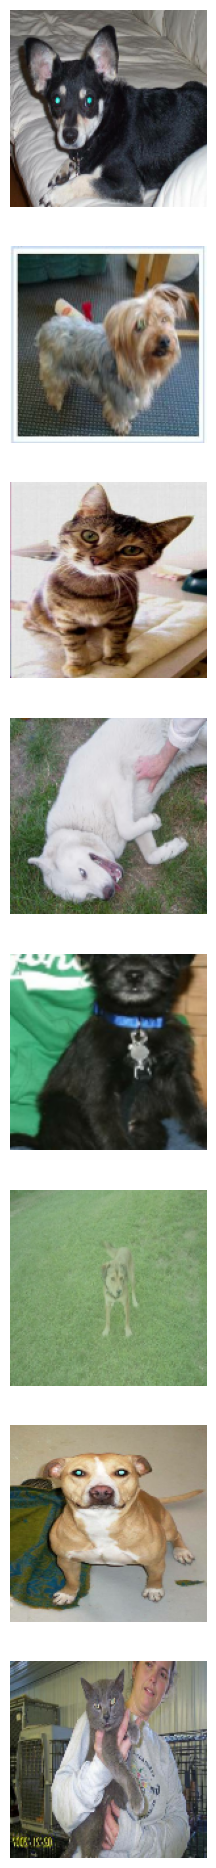

In [6]:
# 6
# train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
#                                                      directory=train_dir,
#                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                      class_mode='binary')

# augmented_images = [train_data_gen[0][0][0] for i in range(5)]
new_img_arr = sample_images_arr(train_data_gen, num_images = 8)

plotImages(new_img_arr)

In [11]:
# 7
# model = Sequential([InputLayer(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)),
#                     Conv2D(filters = 100, kernel_size = 8, strides = 2, padding = 'valid', activation = 'relu'),
#                     BatchNormalization(),
#                     MaxPool2D(pool_size = 2, strides = 2),
#                     Conv2D(filters = 20, kernel_size = 4, strides = 1, padding = 'valid', activation = 'relu'),
#                     BatchNormalization(),
#                     MaxPool2D(pool_size = 2, strides = 2),
#                     Flatten(),
#                     Dense(units = 128, activation = 'relu'),
#                     BatchNormalization(),
#                     Dense(units = 32, activation = 'relu'),
#                     BatchNormalization(),
#                     Dense(units = 2, activation = 'sigmoid')])

model = Sequential([InputLayer(shape = (IMG_WIDTH, IMG_HEIGHT, 3)),
                    Conv2D(filters = 140, kernel_size = 8, strides = 2, padding = 'valid', activation = 'relu'),
                    MaxPool2D(pool_size = 2, strides = 2),
                    Dropout(rate = 0.15),
                    BatchNormalization(),
                    Conv2D(filters = 80, kernel_size = 6, strides = 1, padding = 'valid', activation = 'relu'),
                    MaxPool2D(pool_size = 2, strides = 2),
                    Dropout(rate = 0.15),
                    BatchNormalization(),
                    Conv2D(filters = 20, kernel_size = 4, strides = 1, padding = 'valid', activation = 'relu'),
                    MaxPool2D(pool_size = 2, strides = 2),
                    Dropout(rate = 0.15),
                    BatchNormalization(),
                    Flatten(),
                    Dense(units = 128, activation = 'relu'),
                    BatchNormalization(),
                    Dense(units = 64, activation = 'relu'),
                    BatchNormalization(),
                    Dense(units = 16, activation = 'relu'),
                    BatchNormalization(),
                    Dense(units = 1, activation = 'sigmoid')])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 140)    │        27,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 36, 140)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 36, 36, 140)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 36, 36, 140)    │           560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 80)     │       403,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15, 15, 80)     │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 20)     │        25,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        92,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 559,313 (2.13 MB)

 Trainable params: 558,417 (2.13 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
# 8
model.compile(optimizer = Adam(learning_rate = 0.01), loss = CategoricalCrossentropy(), metrics = ['accuracy'])
history = model.fit(train_data_gen, validation_data = val_data_gen, epochs = 20, verbose = 1)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.5944 - loss: 0.0000e+00 - val_accuracy: 0.4990 - val_loss: 0.0000e+00
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.6659 - loss: 0.0000e+00 - val_accuracy: 0.5370 - val_loss: 0.0000e+00
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6839 - loss: 0.0000e+00 - val_accuracy: 0.6420 - val_loss: 0.0000e+00
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7140 - loss: 0.0000e+00 - val_accuracy: 0.6290 - val_loss: 0.0000e+00
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7446 - loss: 0.0000e+00 - val_accuracy: 0.5380 - val_loss: 0.0000e+00
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7589 - loss: 0.0000e+00 - val_accuracy: 0.5850 - val_loss: 0.0000e+00
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7586 - loss: 0.0000e+00 - val_accuracy: 0.6600 - val_loss: 0.0000e+00
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - 

ValueError: x and y must have same first dimension, but have shapes (15,) and (20,)

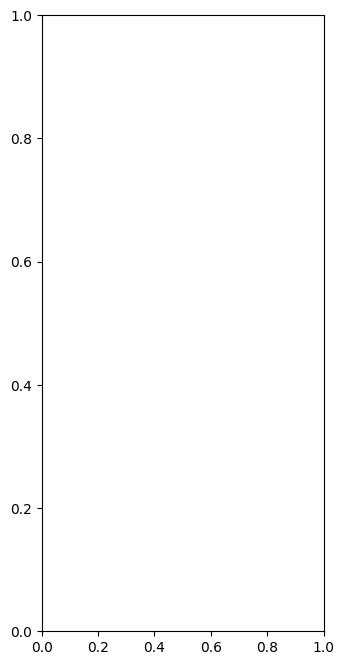

In [10]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")